# Here we go!
## Lets make mountaincar first

2021-11-25 13:58:15.357 python[44547:20076850] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc1fb899960>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 13:58:15.358 python[44547:20076850] Warning: Expected min height of view: (<NSButton: 0x7fc1fb95cf70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 13:58:15.361 python[44547:20076850] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc1fb95fd50>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 13:58:15.362 python[44547:20076850] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc1fb96a570>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


state vector dim = 2
n_actions = 3


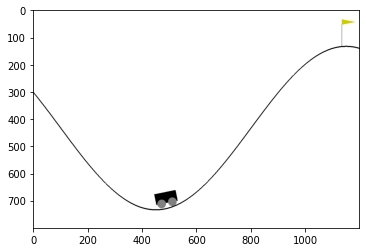

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [2]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("MountainCar-v0").env
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, p = probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [1]:
import operator

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    """
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    if any(rewards_batch > reward_threshold):
        oper = operator.gt ## >
    else: 
        oper = operator.ge ## >=
        
    elite_states =  [i for i, j in zip(states_batch, rewards_batch) if oper(j, reward_threshold)]
    elite_actions = [i for i, j in zip(actions_batch, rewards_batch) if oper(j, reward_threshold)]
    
    ## Flatten
    elite_states = [i for sublist in elite_states for i in sublist]
    elite_actions = [i for sublist in elite_actions for i in sublist]
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [2]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [2]:
from sklearn.neural_network import MLPClassifier
from joblib import Parallel, delayed

mean reward = -131.910, threshold=-110.000


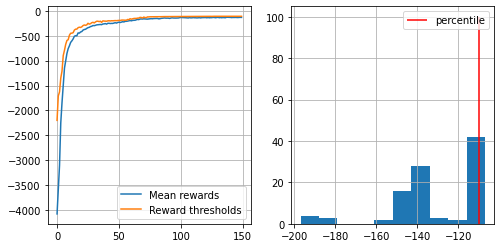

first_win_i=85
best_reward=-128.91


In [59]:
env.reset()

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    
    # solver='sgd',                 ## Converges extremely slowly without proper tuning
    # learning_rate='invscaling',
    # learning_rate='adaptive',
    
    # max_iter=300,  ## tried from 100 to 300 - doesn't help much
)
agent.partial_fit([env.reset()] * 12, [2]*10 + [1] + [0], [2]*10 + [1] + [0]) # initiate with lots of "right" movements

n_sessions = 100
percentile = 80
num_of_last_sessions = 5 ## Меньше зависим от рандома. В нейронку попадает в N+1 раз больше элитных сессий, итоговый результат лучше
zero_check = 0 if num_of_last_sessions == 0 else 100500  ## На случай, если num_of_last_sessions == 0, не будем сохранять старые сессии
log = []

cumul_states = []
cumul_actions = []
cumul_rewards = []

is_win = False
best_reward = -10000

for i in range(150):
    # generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, t_max=11000) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(lambda session: np.array(session, dtype='object'), zip(*sessions))
    
    curr_mean_reward = np.mean(rewards_batch)
    if round(curr_mean_reward) == -11000:
        raise Exception('Restart training for better initial random!')

    ## Adding prev N sessions to threshold calculation
    cumul_states =  cumul_states[-num_of_last_sessions:zero_check]  + [list(states_batch)]
    cumul_actions = cumul_actions[-num_of_last_sessions:zero_check] + [list(actions_batch)]
    cumul_rewards = cumul_rewards[-num_of_last_sessions:zero_check] + [list(rewards_batch)]

    elite_states, elite_actions = select_elites(
        [i for sublist in cumul_states for i in sublist], 
        [i for sublist in cumul_actions for i in sublist], 
        [i for sublist in cumul_rewards for i in sublist], 
        percentile=percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[min(0, np.min(rewards_batch)), np.max(rewards_batch)])

    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > -150:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > -150) & (~is_win):
        first_win_i = i
        is_win = True
        
print(f'{first_win_i=}')
print(f'{best_reward=}')

In [37]:
## num_of_last_sessions = 0, first_win_i=140, final -143.580, best -143.58
## num_of_last_sessions = 3, first_win_i=94,  final -132.330, best -131.53
## num_of_last_sessions = 5, first_win_i=85,  final -131.910, best -128.91
## For more complex MLP (256, 256, 128) results were almost equally good for every num_of_last_sessions

In [60]:
agent = best_agent

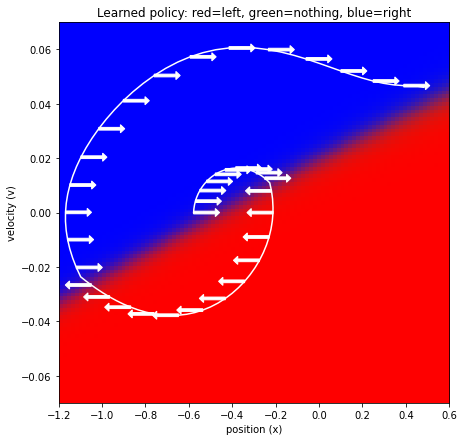

In [61]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent)

# LunarLander-v2

- Основной трюк - выставить побольше шагов в каждой игре. При 20к уже начинает сходиться
- Архитектура сети тоже значительно сложнее

2021-11-25 14:30:58.764 python[44874:20110177] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8b76ddd1b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 14:30:58.764 python[44874:20110177] Warning: Expected min height of view: (<NSButton: 0x7f8b7702c860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 14:30:58.767 python[44874:20110177] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8b76f6fa10>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-11-25 14:30:58.768 python[44874:20110177] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8b7742f310>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


state vector dim = 8
n_actions = 4


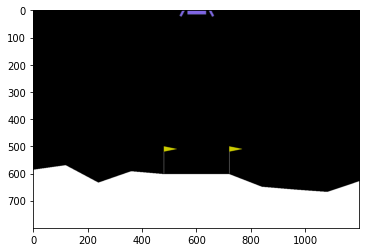

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLander-v2").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

In [20]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("LunarLander-v2").env
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]
        
        # use the probabilities you predicted to pick an action
        a = np.random.choice(n_actions, p = probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
            
    return states, actions, total_reward

mean reward = 217.914, threshold=243.321


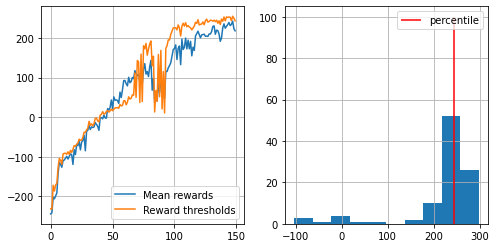

best_reward=242.43475399688003
first_win_i=51
first_win_i_v2=51


In [30]:
from sklearn.neural_network import MLPClassifier

env.reset()

agent = MLPClassifier(
    hidden_layer_sizes= (256, 256, 128), # (256, 256, 128), ## almost works with num_of_last_elites = 0
    activation='tanh',
    # learning_rate='adaptive',
    max_iter=250,
)
agent.partial_fit([env.reset()] * n_actions, list(range(n_actions)), list(range(n_actions))) 

n_sessions = 100
percentile = 50
num_of_last_sessions = 1 ## Меньше зависим от рандома. В нейронку попадает в N+1 раз больше элитных сессий, итоговый результат лучше
zero_check = 0 if num_of_last_sessions == 0 else 100500  ## На случай, если num_of_last_sessions == 0, не будем сохранять старые сессии
log = []

cumul_states = []
cumul_actions = []
cumul_rewards = []

is_win = False
best_reward = -10000

for i in range(150):
    # generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, t_max=20000) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(lambda session: np.array(session, dtype='object'), zip(*sessions))
    
    curr_mean_reward = np.mean(rewards_batch)

    ## Adding prev N sessions to threshold calculation
    cumul_states =  cumul_states[-num_of_last_sessions:zero_check]  + [list(states_batch)]
    cumul_actions = cumul_actions[-num_of_last_sessions:zero_check] + [list(actions_batch)]
    cumul_rewards = cumul_rewards[-num_of_last_sessions:zero_check] + [list(rewards_batch)]

    elite_states, elite_actions = select_elites(
        [i for sublist in cumul_states for i in sublist], 
        [i for sublist in cumul_actions for i in sublist], 
        [i for sublist in cumul_rewards for i in sublist], 
        percentile=percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[min(0, np.min(rewards_batch)), np.max(rewards_batch)])

    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    
    # if np.mean(rewards_batch_curr) > 50:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > 50) & (~is_win):
        first_win_i = i
        is_win = True
        
first_win_i_v2 = np.argmax(np.array([i for i, j in log]) > 50)  ## Извлекаю из логов на случай, если продолжаю обучение не с начала
print(f'{best_reward=}')
print(f'{first_win_i=}')
print(f'{first_win_i_v2=}')

In [32]:
agent = best_agent

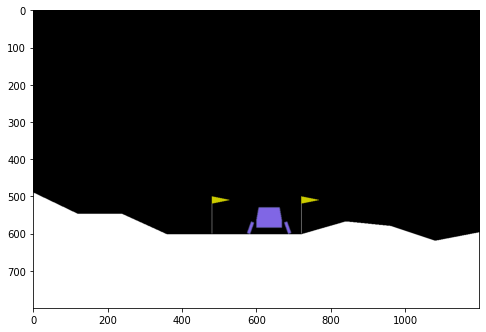

In [35]:
from IPython import display

plt.figure(figsize=(8, 6))
display.clear_output(wait=True)

s = env.reset()
for t in range(20000):
    plt.gca().clear()
    
    probs = agent.predict_proba([s])[0]
    a = np.random.choice(n_actions, p = probs)
    s, _, done, _ = env.step(a)

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)

# MountainCarContinuous-v0

Эта задачка значительно проще, чем LunarLander, поэтому её решил первой.

В лунной задаче уже будет более правильное и продвинутое решение, но для тачки хватит и того что есть здесь
- Рандомим первые несколько итераций, причем с каждой итерацией число рандомных шагов сокращается
- После рандомных шагов начинаем предсказывать агентом
- К этим предсказаниям добавляем случайный шум, привносящий долю исследования

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCarContinuous-v0").env

In [94]:
def generate_session(agent, rand_steps, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("MountainCarContinuous-v0").env
    states, actions = [], []
    total_reward = 0

    s = env.reset()
    
    bound_low =  env.action_space.low[0]
    bound_high = env.action_space.high[0]

    for t in range(t_max):
        if t >= rand_steps:
            a = agent.predict([s])[0] + random.normalvariate(0, 0.3) ## adding some noise to predictions
            a = [min(max(a, bound_low), bound_high)]
        else:
            a = np.random.rand(1)[0]*2-1

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

mean reward = 94.560, threshold=95.471


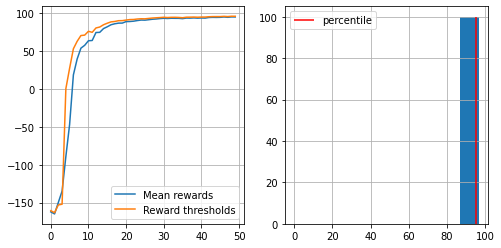

first_win_i=24
best_reward=94.61568881563191


In [98]:
env.reset()

from sklearn.neural_network import MLPRegressor

agent = MLPRegressor(
    hidden_layer_sizes=(32, 32, 16),
    activation='tanh',
)

agent.partial_fit(
    np.zeros(env.observation_space.shape).reshape(1, -1),
    np.zeros(env.action_space.shape)
)
    
n_sessions = 100
percentile = 80
num_of_last_sessions = 1 ## Меньше зависим от рандома. В нейронку попадает в N+1 раз больше элитных сессий, итоговый результат лучше
zero_check = 0 if num_of_last_sessions == 0 else 100500  ## На случай, если num_of_last_sessions == 0, не будем сохранять старые сессии
log = []

cumul_states = []
cumul_actions = []
cumul_rewards = []

is_win = False
best_reward = -10000
    
max_rand_steps = 200
min_rand_steps = 0
decay_rand_steps = 20
    
for i in range(50):
    rand_steps = max(min_rand_steps, max_rand_steps - min(max_rand_steps, i*decay_rand_steps))
    
    # generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, rand_steps, t_max=11000) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(lambda session: np.array(session, dtype='object'), zip(*sessions))
    
    curr_mean_reward = np.mean(rewards_batch)
    if round(curr_mean_reward) == -11000:
        raise Exception('Restart training for better initial random!')

    ## Adding prev N sessions to threshold calculation
    cumul_states =  cumul_states[-num_of_last_sessions:zero_check]  + [list(states_batch)]
    cumul_actions = cumul_actions[-num_of_last_sessions:zero_check] + [list(actions_batch)]
    cumul_rewards = cumul_rewards[-num_of_last_sessions:zero_check] + [list(rewards_batch)]

    elite_states, elite_actions = select_elites(
        [i for sublist in cumul_states for i in sublist], 
        [i for sublist in cumul_actions for i in sublist], 
        [i for sublist in cumul_rewards for i in sublist], 
        percentile=percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[min(0, np.min(rewards_batch)), np.max(rewards_batch)])

    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > 90:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > 90) & (~is_win):
        first_win_i = i
        is_win = True
        
print(f'{first_win_i=}')
print(f'{best_reward=}')

# LunarLanderContinuous-v2

- Много времени ушло на ускорение процесса генерации сессий. Всё что можно было вынести из цикла For - было вынесено.
- Просветление наступило от статьи https://habr.com/ru/company/hsespb/blog/444428/
- Правильно задаем функцию, которая будет создавать рандомный шум
  - Во-первых, внутри итерации на каждом шаге либо предсказываем агентом, либо делаем случайное действие
  - Во-вторых, с каждым шагом вероятность выбрать случайное действие вместо агента снижается с max_epsilon до min_epsilon
  - В-третьих, с каждой итерацией амплитуда случайного шума снижается - иначе так и не сможем сойтись
- Количество шагов в каждой итерации делаем небольшим, около 600. Аппарат вообще должен садиться за 100-200 шагов, больше 600 не имеет смысла.
- Количество итераций делаем побольше - чтобы агент успел потренироваться с шумом большой амплитуды
  - На поздник итерациях шум снижается почти до нуля - и это позволит агенту отвыкнуть от постоянного шума
  - Если остановить процесс сразу после сходжения к среднему=200, то без добавления шума агент просто не сможет приземлить аппарат

In [103]:
def make_some_noise(t_max, curr_iter):
    '''
    Генерируем случайный шум отдельно для бокового и главного двигателей
    Затем обнуляем шум случайным образом в зависимости от того, на каком шаге находимся
    Сначала оставляем max_epsilon строк, под конец необнуленными остаются всего min_epsilon строк
    '''
    
    left_right = np.random.uniform(0.5, 1, t_max) * np.random.choice([-1,1], t_max)
    up_down = np.random.uniform(-0.7, 0.7, t_max)
    random_noise = list(zip(up_down, left_right))

    decay_noise = 0.997
    decay_noise = [decay_noise**curr_iter for _ in range(t_max)]
    
    max_epsilon = 0.5
    min_epsilon = 0.1
    decay_epsilon = 1 ## 0.996

    epsilon = [
        (max_epsilon - (max_epsilon - min_epsilon)* t / t_max) # * (decay_epsilon**curr_iter)
        for t in range(t_max)
    ]
    
    random_noise = [
        [n * noise_mult for n in noise] if rand_num < eps else [0,0] 
        for noise, eps, rand_num, noise_mult
        in zip(random_noise, epsilon, np.random.rand(t_max), decay_noise)
    ]
    
    return random_noise

In [104]:
def generate_session(agent, curr_iter, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("LunarLanderContinuous-v2").env
    states, actions = [], []
    total_reward = 0

    s = env.reset()
    
    bound_low =  env.action_space.low
    bound_high = env.action_space.high
    
    random_noise = make_some_noise(t_max, curr_iter)

    for t in range(t_max):
        a = [min(max(i, j), k) for i,j,k in zip(
            agent.predict([s])[0] + random_noise[t], 
            bound_low, 
            bound_high)
            ]

        states.append(s)
        actions.append(a)
        
        s, r, done, info = env.step(a)

        total_reward += r
        if done:
            break
            
    return states, actions, total_reward

mean reward = 236.478, threshold=281.072


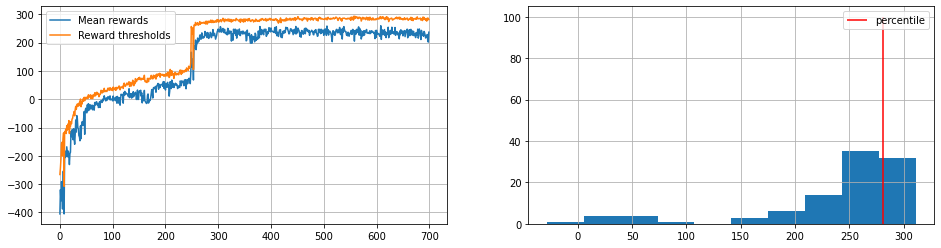

first_win_i=257
best_reward=259.15382750496906


In [76]:
env.reset()

from sklearn.neural_network import MLPRegressor

agent = MLPRegressor(
    hidden_layer_sizes=(400, 200),#(256, 256, 128),
    activation='tanh',
)

agent.partial_fit(
    np.zeros(env.observation_space.shape).reshape(1, -1),
    np.zeros(env.action_space.shape).reshape(1, -1)
)
    
n_sessions = 100
percentile = 75
num_of_last_sessions = 2 ## Меньше зависим от рандома. В нейронку попадает в N+1 раз больше элитных сессий, итоговый результат лучше
zero_check = 0 if num_of_last_sessions == 0 else 100500  ## На случай, если num_of_last_sessions == 0, не будем сохранять старые сессии
log = []

cumul_states = []
cumul_actions = []
cumul_rewards = []

is_win = False
best_reward = -10000

all_steps = 700

## Number of max steps for each game. Gradually increasing in each iteration
## Don't make it big: all good tries usually end in first hundrends, at it takes A LOT of time to generate thousands of steps
t_max_start = 600
t_max_end = 800

## t_max will be in logspace to speed up first iterations
t_max_list = np.logspace(np.log10(t_max_start), np.log10(t_max_end), num=all_steps, dtype='int')
    
for i in range(all_steps):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, i, t_max=t_max_list[i]) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(lambda session: np.array(session, dtype='object'), zip(*sessions))
    
    curr_mean_reward = np.mean(rewards_batch)

    ## Adding prev N sessions to threshold calculation
    cumul_states =  cumul_states[-num_of_last_sessions:zero_check]  + [list(states_batch)]
    cumul_actions = cumul_actions[-num_of_last_sessions:zero_check] + [list(actions_batch)]
    cumul_rewards = cumul_rewards[-num_of_last_sessions:zero_check] + [list(rewards_batch)]

    elite_states, elite_actions = select_elites(
        [i for sublist in cumul_states for i in sublist], 
        [i for sublist in cumul_actions for i in sublist], 
        [i for sublist in cumul_rewards for i in sublist], 
        percentile=percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[min(0, np.min(rewards_batch)), np.max(rewards_batch)])

    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > 200:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > 200) & (~is_win):
        first_win_i = i
        is_win = True
        
    gc.collect()

print(f'{first_win_i=}')
print(f'{best_reward=}')

262.0447259346034
272


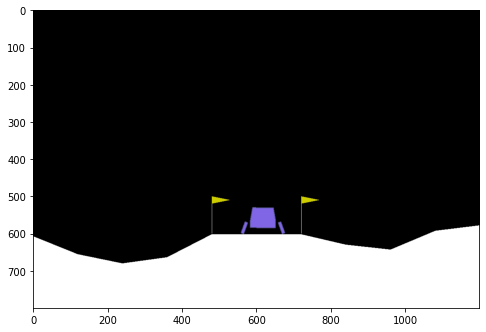

In [88]:
from IPython import display

plt.figure(figsize=(8, 6))
display.clear_output(wait=True)

s = env.reset()

tr = 0

t_max = 700

bound_low =  env.action_space.low
bound_high = env.action_space.high

## Same noise as in generate_sessions
random_noise = make_some_noise(t_max, t_max)


for t in range(t_max):
    plt.gca().clear()
    
    a = [min(max(i, j), k) for i,j,k in zip(
        agent.predict([s])[0] + random_noise[t], 
        bound_low, 
        bound_high)
        ]

    # a = agent.predict([s])[0]
    
    s, r, done, _ = env.step(a)
    tr += r

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))
    
    ## Закомменть следующие строки, чтобы ускорить отрисовку в открытом неподалеку окне
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # print(a)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)
print(tr)
print(t)

# LunarLanderContinuous-v2 - неоптимальное решение

Моё первоначальное решение. Очень неоптимальное, финальный агент сильно зависит от рандомного шума
- Оптимально будет потом переделать через Q Learning
- Через кросс-энтропию пришлось как следует разобраться в свойствах этой игры
- Приходится генерировать случайный шум отдельно для боковых и вертикальных движений
- Сначала шум работает в полную силу, и после устаканивания агента шум начинает обрезаться
- Без такого сильного шума модель наконец сходится к 200

In [8]:
import gc
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLanderContinuous-v2").env


In [4]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10], is_clear_output=True):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

#     if is_clear_output:
#         clear_output(True)
#     print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[16, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    if is_clear_output:
        clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    
    plt.show()

In [577]:
def make_some_noise(t_max, best_reward):
    ## ------------------------------------------
    ## Movement from left to right
    left_right = []
    left_right_sign = 1

    ## For some steps (cnt_rows) we will move only in one direction, then change direction 
    while len(left_right) < t_max:
        cnt_rows = int(np.random.uniform(1, 6))
        left_right += list(np.random.uniform(0.2, 1, cnt_rows) * left_right_sign) ## some small movements
        left_right_sign *= -1

    ## Tricky part: initial iterations will use maximum values left-right noise untill we establish stable agent
    ## First half (1/lr_mult_speed) of steps will use left_right noise, others will be filled with zeros
    ## The first half noise also decays from 1 to 0 equally for each step
    if best_reward >= 80:
    # if best_reward >= 100:

        ## Decrese noise in first 1/2 steps from 100% to 0%
        lr_mult_speed = 2  ## 3 converges even faster

        lr_mult = np.arange(len(left_right)//lr_mult_speed, 0, step=-1) / (len(left_right)//lr_mult_speed)

        ## noise for other 1/2 steps is zero
        lr_mult = np.concatenate((lr_mult, np.zeros(len(left_right) - len(lr_mult))))

        left_right *= lr_mult


    ## ------------------------------------------
    ## Movement for main engine (upper movement)

    ## Initial noise
    up_down = np.random.uniform(-0.7, 0.7, len(left_right))

    ## Once again - untill we establish stable agent we will not decrease noise much
    if best_reward >= 60:

        ## Decrese noise in first 1/3 steps from 100% to 0%
        up_down_mult_speed = 3
        up_down_mult = np.arange(len(up_down)//up_down_mult_speed, 0, step=-1) / (len(up_down)//up_down_mult_speed)

        ## noise for other 2/3 steps is zero
        up_down_mult = np.concatenate((up_down_mult, np.zeros(len(up_down) - len(up_down_mult))))
    else:
        ## Decrese noise equally for each step from 100% to 0%
        up_down_mult = np.arange(len(up_down), 0, step=-1) / len(up_down)

    up_down *= up_down_mult


    ## ------------------------------------------
    random_noise = list(zip(up_down, left_right))
    
    return random_noise

In [624]:
def generate_session(agent, best_reward, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    env = gym.make("LunarLanderContinuous-v2").env
    states, actions = [], []
    total_reward = 0

    s = env.reset()
    
    bound_low =  env.action_space.low
    bound_high = env.action_space.high
    
    random_noise = make_some_noise(t_max, best_reward)

    for t in range(t_max):
        a = [min(max(i, j), k) for i,j,k in zip(
            agent.predict([s])[0] + random_noise[t], 
            bound_low, 
            bound_high)
            ]

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
            
    return states, actions, total_reward

mean reward = 202.900, threshold=279.309


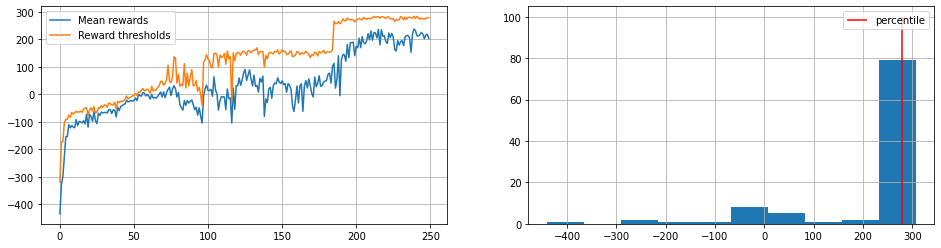

first_win_i=202
best_reward=238.12858539954178


In [552]:
env.reset()

from sklearn.neural_network import MLPRegressor

agent = MLPRegressor(
    hidden_layer_sizes=(400, 200),#(256, 256, 128),
    activation='tanh',
)

agent.partial_fit(
    np.zeros(env.observation_space.shape).reshape(1, -1),
    np.zeros(env.action_space.shape).reshape(1, -1)
)
    
n_sessions = 100
percentile = 75
num_of_last_sessions = 2 ## Меньше зависим от рандома. В нейронку попадает в N+1 раз больше элитных сессий, итоговый результат лучше
zero_check = 0 if num_of_last_sessions == 0 else 100500  ## На случай, если num_of_last_sessions == 0, не будем сохранять старые сессии
log = []

cumul_states = []
cumul_actions = []
cumul_rewards = []

is_win = False
best_reward = -10000

all_steps = 250

## Number of max steps for each game. Gradually increasing in each iteration
## Don't make it big: all good tries usually end in first hundrends, at it takes A LOT of time to generate thousands of steps
t_max_start = 600
t_max_end = 800

## t_max will be in logspace to speed up first iterations
t_max_list = np.logspace(np.log10(t_max_start), np.log10(t_max_end), num=all_steps, dtype='int')
    
for i in range(all_steps):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, best_reward, t_max=t_max_list[i]) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(lambda session: np.array(session, dtype='object'), zip(*sessions))
    
    curr_mean_reward = np.mean(rewards_batch)

    ## Adding prev N sessions to threshold calculation
    cumul_states =  cumul_states[-num_of_last_sessions:zero_check]  + [list(states_batch)]
    cumul_actions = cumul_actions[-num_of_last_sessions:zero_check] + [list(actions_batch)]
    cumul_rewards = cumul_rewards[-num_of_last_sessions:zero_check] + [list(rewards_batch)]

    elite_states, elite_actions = select_elites(
        [i for sublist in cumul_states for i in sublist], 
        [i for sublist in cumul_actions for i in sublist], 
        [i for sublist in cumul_rewards for i in sublist], 
        percentile=percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[min(0, np.min(rewards_batch)), np.max(rewards_batch)])

    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > 200:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > 200) & (~is_win):
        first_win_i = i
        is_win = True
        
    gc.collect()

print(f'{first_win_i=}')
print(f'{best_reward=}')

285.3290126551005
255


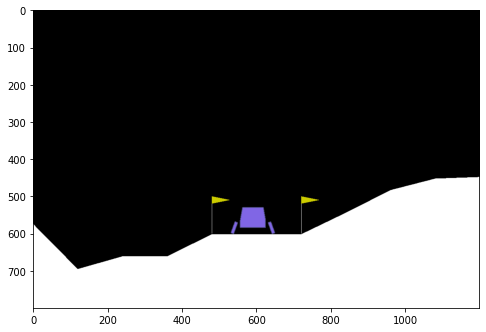

In [588]:
from IPython import display

plt.figure(figsize=(8, 6))
display.clear_output(wait=True)

s = env.reset()

tr = 0

t_max = 800
best_reward = 200

bound_low =  env.action_space.low
bound_high = env.action_space.high

random_noise = make_some_noise(t_max, best_reward)

## ------------------------------------------
## END Same noise as in generate_sessions

for t in range(t_max):
    plt.gca().clear()
    
    a = [min(max(i, j), k) for i,j,k in zip(
        agent.predict([s])[0] + random_noise[t], 
        bound_low, 
        bound_high)
        ]
    
    s, r, done, _ = env.step(a)
    tr += r

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # print(a)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output(wait=True)
print(tr)
print(t)

# Устаревшая версия MountainCar-v0
- В ней попробовал сохранять Элитные сессии (а не просто ВСЕ сессии) с предыдущих N шагов
- Получается сильное переобучение на "удачные" сессии, коими и являются элитные 
- Чтобы эта устаревшая версия снова заработала, убери из select_elites шаг Flatten и также возвращай элитные реворды

In [1]:
import operator

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    """
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    if any(rewards_batch > reward_threshold):
        oper = operator.gt ## >
    else: 
        oper = operator.ge ## >=
        
    elite_states =  [i for i, j in zip(states_batch, rewards_batch) if oper(j, reward_threshold)]
    elite_actions = [i for i, j in zip(actions_batch, rewards_batch) if oper(j, reward_threshold)]
    elite_rewards = [i for i in rewards_batch if oper(i, reward_threshold)]
    
    return elite_states, elite_actions, elite_rewards

mean reward = -113.330, threshold=-104.000


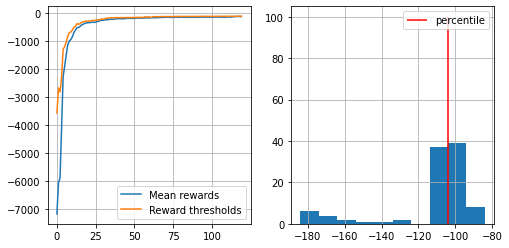

67
-111.5


In [34]:
env.reset()

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
    # learning_rate='adaptive', ## gets way more stable, but doesn't achieve the same best quality and tops at -131.42
    # max_iter=150,
)
agent.partial_fit([env.reset()] * 12, [2]*10 + [1] + [0], [2]*10 + [1] + [0]) # initiate with lots of "right" movements

n_sessions = 100
percentile = 80
num_of_last_elites = 2 ## Меньше зависим от рандома. На низких застревает на плато, на высоких начинает сильно переобучаться и расходится 
zero_check = 0 if num_of_last_elites == 0 else 100500  ## На случай, если num_of_last_elites == 0, не будем сохранять старых элитов
log = []

prev_elite_states = []
prev_elite_actions = []
prev_elite_rewards = []

is_win = False
best_reward = -10000

for i in range(120):
    # generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, t_max=11000) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    rewards_batch_curr = rewards_batch

    ## Adding prev elites to threshold calculation
    if i > 0:
        states_batch =  [i for sublist in prev_elite_states[-num_of_last_elites:zero_check]  for i in sublist] + list(states_batch)
        actions_batch = [i for sublist in prev_elite_actions[-num_of_last_elites:zero_check] for i in sublist] + list(actions_batch)
        rewards_batch = [i for sublist in prev_elite_rewards[-num_of_last_elites:zero_check] for i in sublist] + list(rewards_batch)

    elite_states, elite_actions, elite_rewards = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    ## Add current elites to last N elites
    prev_elite_states =  prev_elite_states[-num_of_last_elites:zero_check]  + [elite_states]
    prev_elite_actions = prev_elite_actions[-num_of_last_elites:zero_check] + [elite_actions]
    prev_elite_rewards = prev_elite_rewards[-num_of_last_elites:zero_check] + [elite_rewards]
    
    ## Flatten
    elite_states = [i for sublist in prev_elite_states for sublist_x2 in sublist for i in sublist_x2]
    elite_actions = [i for sublist in prev_elite_actions for sublist_x2 in sublist for i in sublist_x2]
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch_curr, log, percentile, reward_range=[min(0, np.min(rewards_batch_curr)), np.max(rewards_batch_curr)])

    curr_mean_reward = np.mean(rewards_batch_curr)
    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > -150:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > -150) & (~is_win):
        print(f"You Win! Iteration: {i}")
        first_win_i = i
        is_win = True
    
    if (curr_mean_reward < -500) & (is_win):
        print(f"Got too unstable! Stopping at iteration: {i}")
        break
        
print(first_win_i)
print(best_reward)

In [10]:
## 71 for num_of_last_elites = 5, final -163,    best -113    , got unstable with means down to -2k
## 46 for num_of_last_elites = 3, final -131.87, best -123.74
## ?? for num_of_last_elites = 2, final -4668,   best -109.17 , got unstable with means down to -5k
## 66 for num_of_last_elites = 1, final -131.87, best -131.87

# Устаревшая версия LunarLander-v2
- Аналогично с тачкой - версия, где сохранял N последних элитных сессий

mean reward = 60.487, threshold=32.742


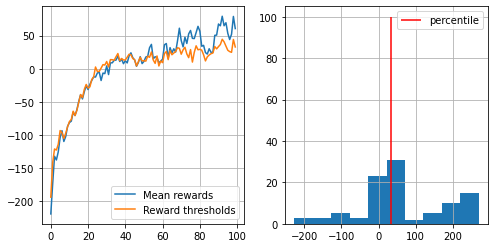

69
79.06038774581022


In [62]:
from sklearn.neural_network import MLPClassifier

env.reset()

agent = MLPClassifier(
    hidden_layer_sizes= (256, 256, 128), # (256, 256, 128), ## almost works with num_of_last_elites = 0
    activation='tanh',
    learning_rate='adaptive',
    max_iter=250,
)
agent.partial_fit([env.reset()] * n_actions, list(range(n_actions)), list(range(n_actions))) 

n_sessions = 100
percentile = 50
num_of_last_elites = 0 ## Меньше зависим от рандома. На низких застревает на плато, на высоких начинает сильно переобучаться и расходится 
zero_check = 0 if num_of_last_elites == 0 else 100500  ## На случай, если num_of_last_elites == 0, не будем сохранять старых элитов
log = []

prev_elite_states = []
prev_elite_actions = []
prev_elite_rewards = []

is_win = False
best_reward = -10000

for i in range(100):
    # generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent, t_max=3000) for _ in range(n_sessions))
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    rewards_batch_curr = rewards_batch

    ## Adding prev elites to threshold calculation
    if i > 0:
        states_batch =  [i for sublist in prev_elite_states[-num_of_last_elites:zero_check]  for i in sublist] + list(states_batch)
        actions_batch = [i for sublist in prev_elite_actions[-num_of_last_elites:zero_check] for i in sublist] + list(actions_batch)
        rewards_batch = [i for sublist in prev_elite_rewards[-num_of_last_elites:zero_check] for i in sublist] + list(rewards_batch)

    elite_states, elite_actions, elite_rewards = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    ## Add current elites to last N elites
    prev_elite_states =  prev_elite_states[-num_of_last_elites:zero_check]  + [elite_states]
    prev_elite_actions = prev_elite_actions[-num_of_last_elites:zero_check] + [elite_actions]
    prev_elite_rewards = prev_elite_rewards[-num_of_last_elites:zero_check] + [elite_rewards]
    
    ## Flatten
    elite_states = [i for sublist in prev_elite_states for sublist_x2 in sublist for i in sublist_x2]
    elite_actions = [i for sublist in prev_elite_actions for sublist_x2 in sublist for i in sublist_x2]
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch_curr, log, percentile, reward_range=[min(0, np.min(rewards_batch_curr)), np.max(rewards_batch_curr)])

    curr_mean_reward = np.mean(rewards_batch_curr)
    if curr_mean_reward > best_reward:
        best_reward = curr_mean_reward
        best_agent = agent
    
    # if np.mean(rewards_batch_curr) > 50:
    #     print(f"You Win! Interrupting. Iteration: {i}")
    #     break
    
    if (curr_mean_reward > 50) & (~is_win):
        print(f"You Win! Iteration: {i}")
        first_win_i = i
        is_win = True
    
    if (curr_mean_reward < 0) & (is_win):
        print(f"Got too unstable! Stopping at iteration: {i}")
        break
        
print(first_win_i)
print(best_reward)